# Template for Topic Modelling Text Data using Clustering And Dimension Reduction

## Summary

This notebook outlines how raw text can be leveraged in a way to group the text into clusters of so called 'topics'. Techniques used include:

- KMEANS
- HDBScan
- T-SNE
- Doc2Vec
- Seaborn Plotting.

### Dependencies &amp; Imports

In [52]:
! pip install gensim
! pip install sklearn
! pip install Pandas
! pip install umap
! pip install nltk
! pip install hdbscan
! pip install nltk

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [53]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from random import randint, sample
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.ldamodel import LdaModel
from gensim import corpora
from sklearn import manifold
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

### Data Acquistion &amp; Preparation

In [54]:
df = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/sms_spam.csv")
df.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [55]:
# Do any preprocessing here, the world is your oyster...
df['text'] = df['text'].str.lower()

TaggedDocument objects, a list of objects containing words and a type of user defined tag (typically document IDs), using the TaggedDocument() class from the gensim library. This is the format required for doc2vec vectorisation.

In [56]:
num_samples = len(df)
text_data = df['text'].sample(num_samples).tolist()
tagged_data = [TaggedDocument(words=text, tags=[idx]) for idx, text in enumerate(text_data)]

### Build Doc2Vec Model

In [57]:
model = Doc2Vec(vector_size=500, window=10, min_count=2, workers=4,alpha=0.025, min_alpha=0.001)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=num_samples, epochs=100)

# Save - Useful if your creating a large model.
model.save("d2v.model")

### Use Doc2Vec Model to Infer Text Similarity

Lets Grab some sample data, the specific example used is irrelevant to showcase functionality.

In [58]:
sample_index = 100
test_data = text_data[sample_index]
print(test_data)

feb  &lt;#&gt;  is "i love u" day. send dis to all ur "valued frnds" evn me. if 3 comes back u'll gt married d person u luv! if u ignore dis u will lose ur luv 4 evr


Load our trained model and grab the vector representation of the data we used to train.

In [59]:
model = Doc2Vec.load("d2v.model")
doc_vecs = model.docvecs.vectors_docs
print(doc_vecs[:3])

[[ 0.17288317 -0.03270495 -0.15689498 ...  0.1279914   0.07306982
   0.06306736]
 [ 0.01722467  0.29128656 -0.04528001 ...  0.12568097 -0.22109534
   0.04813117]
 [ 0.03465895 -0.04370061  0.14129975 ...  0.0369569  -0.1997845
  -0.02990755]]


Transform our test sample into a vector representation using our model.

Gather the closest related samples from the training set and print for human consumption.

Note that our input to the ``infer_vector method`` is a list (of type string)

Note also in the formatted print that we grab the original 'tag' of the pre-vectorised text item, in order for us to retrieve the original text from the source ``text_data``

The instances reteievd are based on the consine similarity of the input vectors.

In [60]:
inferred_vector = model.infer_vector([test_data], alpha=0.025, min_alpha=0.001, epochs=100000)
similar_documents = model.docvecs.most_similar([inferred_vector])

num_relatives_to_show = 5
for i in range(num_relatives_to_show):
    print("{0}.".format(i+1), "%s: %s\n" % (similar_documents[i], "".join(text_data[similar_documents[i][0]])))

1. (1412, 0.13729222118854523): my no. in luton 0125698789 ring me if ur around! h*

2. (695, 0.11282996088266373): i'm nt goin, got somethin on, unless they meetin 4 dinner lor... haha, i wonder who will go tis time...

3. (4415, 0.11033183336257935): time n smile r the two crucial things in our life. sometimes time makes us to forget smile, and sometimes someone's smile makes us to forget time gud noon

4. (367, 0.10960260778665543): still otside le..u come 2morrow maga..

5. (1827, 0.1080373153090477): hey, i missed you tm of last night as my phone was on the charge ... *smiles* ... i am meeting a friend shortly



### Dimensionality Reduction

To Enable Plotting.

t-SNE creates a probability distribution using the Gaussian distribution that defines the relationships between the points in high-dimensional space

It also leverages gradient descent and other complex mathmatical techniques to derive the reduced data.

In [61]:
tsne = manifold.TSNE(n_components=2, init='random', metric='cosine', random_state=None, method='barnes_hut')
tsne_model = tsne.fit_transform(doc_vecs)

### HDBSCAN Clustering

Hierarchal clustering approach.

In [62]:
min_cluster_size_impl = 2
tsne_clusters = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size_impl).fit(tsne_model)

### Plot our 2D clusters with Seaborn

Grab a seanborn colour spectrum, assign a colour to a given cluster and plot.

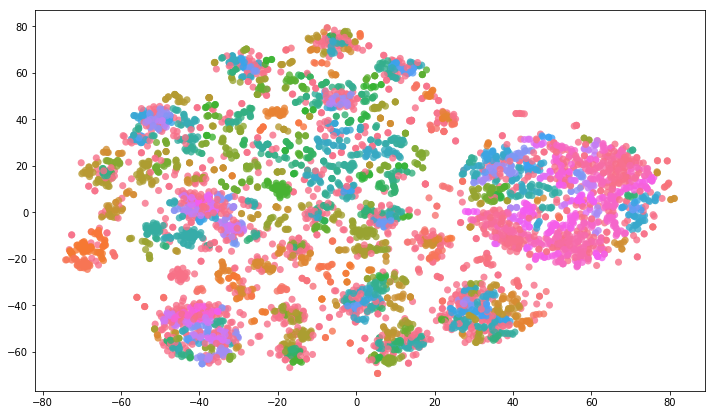

In [79]:
color_palette = sns.color_palette('husl', tsne_clusters.labels_.max()+1)
cluster_colors = [color_palette[x] for x in tsne_clusters.labels_]

plt.scatter(*tsne_model.T, s=50, linewidth=0, c=cluster_colors, alpha=0.8)
plt.gcf().set_size_inches(12, 7)

### Output Data Within Clusters

In [64]:
def print_cluster_information(cluster_number):
    print('Cluster {0}:'.format(cluster_number))
    print('\n')

Every instance in the clusters has a label, if that label matches our target ``cluster_number`` we get that clusters text representation from the original ``text_data`` and print it.

In [65]:
def print_data_in_cluster(cluster_no, clusters, text_data):
    text_in_cluster = []
    for i in range(len(clusters.labels_)):
        if clusters.labels_[i] == cluster_no:
            text_in_cluster.append(text_data[i])
    
    for text in text_in_cluster:
        print(text)

Lets grab a random cluster...

In [66]:
cluster_number = randint(0, tsne_clusters.labels_.max())

print_cluster_information(cluster_number)
print_data_in_cluster(cluster_number, tsne_clusters, text_data)

Cluster 158:


yup i thk cine is better cos no need 2 go down 2 plaza mah.
the 2 oz guy is being kinda flaky but one friend is interested in picking up $ &lt;#&gt;  worth tonight if possible
the length is e same but e top shorter n i got a fringe now. i thk i'm not going liao. too lazy. dun wan 2 distract u also.
im realy soz imat my mums 2nite what about 2moro
haha yeah, 2 oz is kind of a shitload


### KMEANS Clustering Using The Elbow Method

Iterate through several values of 'k' and cluster, while collecting suitable evaluation metrics.

In [67]:
step = 40
max_clusters = 500
sum_of_squared_distances = []
k_superset = range(step, max_clusters, step)

for k in k_superset:
    km = KMeans(n_clusters=k, max_iter=100)
    km = km.fit(tsne_model)
    sum_of_squared_distances.append(km.inertia_)
    
    print("Done", k, "clusters", "Silhouette Coefficient: %0.3f"% 
          metrics.silhouette_score(tsne_model, km.labels_, sample_size=1000, random_state=42))

Done 40 clusters Silhouette Coefficient: 0.400
Done 80 clusters Silhouette Coefficient: 0.411
Done 120 clusters Silhouette Coefficient: 0.360
Done 160 clusters Silhouette Coefficient: 0.358
Done 200 clusters Silhouette Coefficient: 0.362
Done 240 clusters Silhouette Coefficient: 0.363
Done 280 clusters Silhouette Coefficient: 0.367
Done 320 clusters Silhouette Coefficient: 0.366
Done 360 clusters Silhouette Coefficient: 0.338
Done 400 clusters Silhouette Coefficient: 0.353
Done 440 clusters Silhouette Coefficient: 0.344
Done 480 clusters Silhouette Coefficient: 0.327


### Plot the Elbow Graph

For interpretation, the lower the square distances, the more homogenous the clusters.

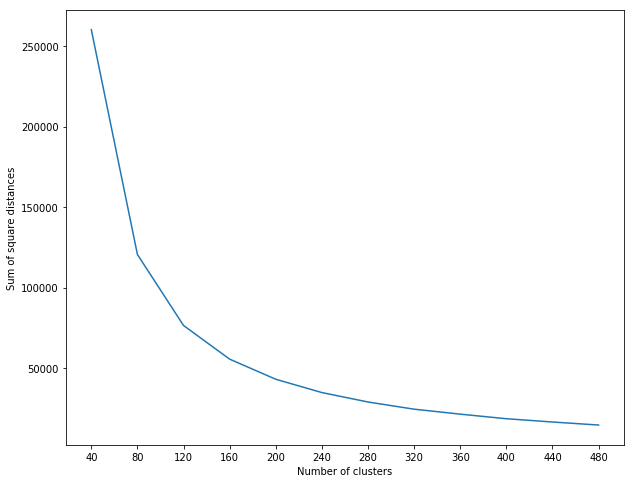

In [68]:
plt.figure(figsize=(10,8))
plt.plot(step * np.asarray(range(1, len(sum_of_squared_distances) + 1)), sum_of_squared_distances)
plt.xlabel("Number of clusters")
plt.ylabel("Sum of square distances")
plt.xticks(range(step, max_clusters, step))
plt.show()

### Plot Clusters

Now we have an idea of the ideal number of clusters according to a suitable error metric, lets fit and assign clusters to our data.

In [69]:
n_clusters = 280

model = KMeans(n_clusters=n_clusters, random_state=42)
model.fit(tsne_model)
y_kmeans = model.predict(tsne_model)

For each possible cluster, grab a different colour.

print the reduced dimension vectorised data, grabbing the 2D post vector points.

In [70]:
colours_map = dict()
for idx, rgb in enumerate(sns.color_palette('husl', n_clusters)):
    colours_map[idx] = rgb
colours = [colours_map[i] for i in y_kmeans]  

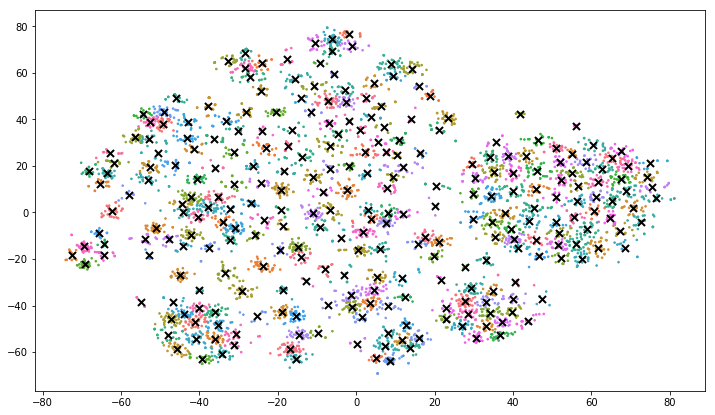

In [71]:
# Plot points with cluster colours
plt.figure(figsize=(12,7))
plt.scatter(tsne_model[:, 0], tsne_model[:, 1], marker=".", s=10, c=colours)
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], 
            marker="x", edgecolor='w', linewidth=2, s=50, c='k')

### Extract Data From KMEANS Clusters

In [72]:
clustering_results_df = pd.DataFrame({"text": text_data, "cluster": y_kmeans})
clustering_results_df.head(5)

,text,cluster
0,yeah we do totes. when u wanna?,181
1,aiyah ok wat as long as got improve can alread...,93
2,i'm thinking that chennai forgot to come for a...,72
3,free msg: single? find a partner in your area!...,68
4,i think i‘m waiting for the same bus! inform m...,176


In [73]:
num_results_to_print = 5
for i in sorted(clustering_results_df['cluster'].unique()):
    print("\nCluster " + str(i) + "\n" + "\n".join(clustering_results_df['text']
                                                  [clustering_results_df['cluster'] == i].values
                                                  [:num_results_to_print]))


Cluster 0
i got it before the new year cos yetunde said she wanted to surprise you with it but when i didnt see money i returned it mid january before the  &lt;#&gt; day return period ended.
i just saw ron burgundy captaining a party boat so yeah
i‘m going to try for 2 months ha ha only joking
yo dude guess who just got arrested the other day
did he just say somebody is named tampa

Cluster 1
i said its okay. sorry
its too late:)but its k.wish you the same.
oh ok no prob..
he also knows about lunch menu only da. . i know
eh den sat u book e kb liao huh...

Cluster 2
did you catch the bus ? are you frying an egg ? did you make a tea? are you eating your mom's left over dinner ? do you feel my love ?
what's up. do you want me to come online?
she's fine. good to hear from you. how are you my dear? happy new year oh.
that sucks. so what do you got planned for your yo valentine? i am your yo valentine aren't i?
what's a feathery bowa? is that something guys have that i don't know about?

C

### LDA Topic Modelling

First, lets tokenise the text data into word tokens, this is what the gensim LDA model expects as input.

Lets use the original but preprocessed dataframe.

In [74]:
df['text_tokens'] = df.text.map(lambda x: RegexpTokenizer(r'\w+').tokenize(x))
df.head()

,type,text,text_tokens
0,ham,"go until jurong point, crazy.. available only ...","[go, until, jurong, point, crazy, available, o..."
1,ham,ok lar... joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,u dun say so early hor... u c already then say...,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,"nah i don't think he goes to usf, he lives aro...","[nah, i, don, t, think, he, goes, to, usf, he,..."


Generate a corpus of unique text tokens

In [75]:
text = df['text_tokens'].values
dictionary = corpora.Dictionary(text)
print(dictionary)

Dictionary(8753 unique tokens: ['amore', 'available', 'buffet', 'bugis', 'cine']...)


Convert the text rows into a bag of words and generate an LDA model.

In [76]:
corpus = [dictionary.doc2bow(text_row) for text_row in text]
ldamodel = LdaModel(corpus, id2word=dictionary, 
                    num_topics=10, passes=5, minimum_probability=0)

Lets see what topics LDA gives us...

In [77]:
ldamodel.print_topics()

[(0,
  '0.061*"you" + 0.041*"to" + 0.021*"i" + 0.020*"are" + 0.016*"a" + 0.014*"me" + 0.013*"and" + 0.012*"what" + 0.012*"call" + 0.011*"your"'),
 (1,
  '0.042*"u" + 0.029*"to" + 0.027*"i" + 0.027*"a" + 0.016*"me" + 0.015*"my" + 0.014*"2" + 0.013*"the" + 0.010*"and" + 0.010*"of"'),
 (2,
  '0.053*"i" + 0.023*"later" + 0.022*"sorry" + 0.018*"ll" + 0.017*"will" + 0.015*"am" + 0.014*"call" + 0.013*"going" + 0.013*"in" + 0.012*"we"'),
 (3,
  '0.048*"you" + 0.034*"i" + 0.021*"a" + 0.019*"are" + 0.019*"how" + 0.018*"is" + 0.018*"my" + 0.016*"the" + 0.013*"good" + 0.013*"do"'),
 (4,
  '0.042*"k" + 0.042*"ok" + 0.027*"pls" + 0.021*"i" + 0.018*"me" + 0.018*"no" + 0.015*"send" + 0.014*"dont" + 0.012*"problem" + 0.012*"right"'),
 (5,
  '0.032*"to" + 0.024*"call" + 0.023*"free" + 0.018*"the" + 0.017*"u" + 0.016*"a" + 0.015*"now" + 0.014*"or" + 0.014*"2" + 0.013*"txt"'),
 (6,
  '0.020*"c" + 0.013*"no" + 0.012*"for" + 0.010*"hi" + 0.010*"ü" + 0.010*"network" + 0.009*"in" + 0.008*"ya" + 0.008*"thanx" 

### Ideas

- Word cloud the contents of the clusters.
- Optimise Doc2Vec Process.
- Determine if you can assign topics to your clusters.
- Determine for a given input, you can assign it to a specific cluster / topic
- Depending on the data, try differing DR methods such as SVD or UMAP
- Much more data cleaning / preprocessing. Stopwords, stems, lemmas, min_frequency etc etc.
- Can you reduce the dimension of the LDA BOW and plot, or reduce dimensions...if you fancy it.
- Add code to enable querying the LDA model for related topics.